# ERA5 climate data

In [1]:
pip install gcsfs

In [2]:
import xarray
import odc.geo.xr
from odc.geo.geom import BoundingBox
import datacube


def load_era5(
    x=None,
    y=None,
    crs="EPSG:4326",
    time=None,  #("2020-01-01 1:00", "2020-01-01 10:00"),
    bands=None,
    chunks=None,
    path="gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
):
    # Lazily load Zarr from Google Cloud Platform
    era5_ds = xarray.open_zarr(path, chunks=chunks, storage_options=dict(token="anon"))

    # Select bands
    era5_ds = era5_ds[bands] if bands is not None else era5_ds

    # Clip to extent
    if x is not None:
        bbox = BoundingBox.from_xy(x, y, crs=crs).to_crs("EPSG:4326")
        era5_ds = era5_ds.sel(
            longitude=slice(bbox.left, bbox.right),
            latitude=slice(bbox.top, bbox.bottom),
        )
        
    # Select time
    if time is not None:
        era5_ds = era5_ds.sel(time=slice(time[0], time[-1]))

    return era5_ds.odc.assign_crs("EPSG:4326")


# Connect to datacube
dc = datacube.Datacube()

## Inspect variables

First lazily load the ERA5 Zarr data to inspect available variables:

In [3]:
# Lazily load Zarr from Google Cloud Platform
era5_ds = xarray.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
    chunks=None,
    storage_options=dict(token="anon"))
era5_ds

<xarray.Dataset> Size: 3PB
Dimensions:                                                          (
                                                                      time: 1089864,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 9MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 5TB ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 5TB ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 5TB ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 5TB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 5TB ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 5TB ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 5TB ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 5TB ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 5TB ...
    zero_degree_level                                                (time, latitude, longitude) float32 5TB ...

## Load satellite data 

In [4]:
from dea_tools.dask import create_local_dask_cluster

client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 3,Total memory: 28.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37957,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 3
Started: Just now,Total memory: 28.21 GiB
Comm: tcp://127.0.0.1:46515,Total threads: 3
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/36481/status,Memory: 28.21 GiB
Nanny: tcp://127.0.0.1:41887,


In [5]:
x = (148.966534, 149.244572)
y = (-35.142143, -35.407755)
time = ("2023-06-01", "2024-06-01")

ds = dc.load(
    product="ga_ls9c_ard_3",
    measurements="nbart_nir",
    x=x,
    y=y,
    time=time,
    group_by="solar_day",
    resolution=(-100, 100),
    dask_chunks={"x": 2048, "y": 2048},
)
ds.load()

<xarray.Dataset> Size: 9MB
Dimensions:      (time: 45, y: 327, x: 291)
Coordinates:
  * time         (time) datetime64[ns] 360B 2023-06-09T23:49:41.782646 ... 20...
  * y            (y) float64 3kB -3.94e+06 -3.94e+06 ... -3.973e+06 -3.973e+06
  * x            (x) float64 2kB 1.534e+06 1.534e+06 ... 1.563e+06 1.563e+06
    spatial_ref  int32 4B 3577
Data variables:
    nbart_nir    (time, y, x) int16 9MB 1713 2140 3854 3302 ... 1667 1689 1940
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Load ERA5 data to match satellite data

In [6]:
era5_subset_ds = load_era5(
    x=x,
    y=y,
    crs="EPSG:4326",
    time=time,
    bands=["temperature"],
    path="gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
)
era5_subset_ds

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 8040, level: 37, latitude: 1, longitude: 1)
Coordinates:
  * latitude     (latitude) float32 4B -35.25
  * level        (level) int64 296B 1 2 3 5 7 10 20 ... 875 900 925 950 975 1000
  * longitude    (longitude) float32 4B 149.0
  * time         (time) datetime64[ns] 64kB 2023-06-01 ... 2024-04-30T23:00:00
    spatial_ref  int32 4B 4326
Data variables:
    temperature  (time, level, latitude, longitude) float32 1MB ...

## Combine with satellite data

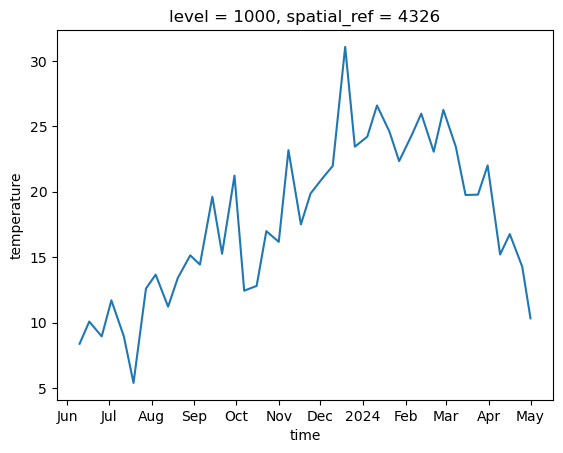

In [7]:
# Extract just temperatures for the lowest level of the atmosphere
era5_temps = era5_subset_ds.temperature.isel(level=-1)

# Extract timesteps matching satellite overpasses 
era5_satellite_temps = era5_temps.sel(time=ds.time, method="nearest")

# Take mean temp for each timestep
era5_mean_temps = era5_satellite_temps.mean(dim=["longitude", "latitude"])

# Plot after converting Kelvin to Celcius
(era5_mean_temps - 273.15).plot()